In [34]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38809")
client

<Client: 'tcp://127.0.0.1:38809' processes=8 threads=32, memory=246.60 GiB>

In [35]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea

from scipy.stats import linregress
import fsspec
import zarr

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import gsw

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [37]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [38]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')
# mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native')

# mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_snap_native')
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native
print(mzz_local_directory)

/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native


# load mon means: SSH, pressure, T,S

In [39]:
# MZZ files have been downloaded. 
# select the SSH dataset
TS_file = mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json'
DEN_file = mzz_local_directory / 'OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json'
PRE_file = mzz_local_directory / 'OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json'
SSH_file = mzz_local_directory / 'SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json'
ICE_file = mzz_local_directory / 'SEA_ICE_CONC_THICKNESS_mon_mean_native_llc090_ECCOV4r5.json'

print(TS_file)
print(DEN_file)
print(PRE_file)
print(SSH_file)

/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json


## load grid

In [40]:
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
access_mode = 'download'

# download root (parent) directory
grid_fnm = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_grid = xr.open_dataset(grid_fnm)
ds_grid

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B ...
    Zu                      (k_u) float32 200B ...
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    dyF                     (tile, j, i) float32 421kB ...
    dyU                     (tile, j_g, i_g) float32 421kB ...
    rLowC                   (tile, j, i) float32 421kB ...
    rSurfC                  (tile, j, i) float32 421kB ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

# 1. read data (all times), SSH, pressure, density, T/S

In [41]:
fs_TS = fsspec.filesystem("reference",     
                       fo=str(TS_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_TS.asynchronous = True
store = zarr.storage.FsspecStore(fs_TS)
ds_TS = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 

# 
fs_DEN = fsspec.filesystem("reference",     
                       fo=str(DEN_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_DEN.asynchronous = True
store = zarr.storage.FsspecStore(fs_DEN)
ds_DEN = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_PRE = fsspec.filesystem("reference",     
                       fo=str(PRE_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_PRE.asynchronous = True
store = zarr.storage.FsspecStore(fs_PRE)
ds_PRE = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_SSH = fsspec.filesystem("reference",     
                       fo=str(SSH_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_SSH.asynchronous = True
store = zarr.storage.FsspecStore(fs_SSH)
ds_SSH = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_ICE = fsspec.filesystem("reference",     
                       fo=str(ICE_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_ICE.asynchronous = True
store = zarr.storage.FsspecStore(fs_ICE)
ds_ICE = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 
# ds_ICE.SIheff

In [42]:
itime = ((ds_PRE.time >= np.array(datetime.datetime(1993,1,1)).astype('datetime64[ns]')) & 
         (ds_PRE.time <= np.array(datetime.datetime(2019,12,31)).astype('datetime64[ns]')))

eta = ds_SSH.SSH[itime,:,:,:].compute() # SSH: REMOVED atm pressure and sea ice effect
etan = ds_SSH.ETAN[itime,:,:,:].compute()
rhoanom = ds_DEN.RHOAnoma[itime,:,:,:].compute()
eta_m = ds_PRE.OBP[itime,:,:,:].compute()

SIheff = ds_ICE.SIheff[itime,:,:,:].compute()
sIceLoad = ds_ICE.sIceLoad[itime,:,:,:].compute()

In [ ]:
rhoanom.shape
rhoanom_tm = rhoanom.mean(dim='time')
rhoanom_tm.shape
# sIceLoad
ds_SSH

In [46]:
g = 9.81
rhoConst = 1029.
sstar = (ds_grid.Depth + etan) / ds_grid.Depth
dzs = ds_grid.drF * ds_grid.hFacC
dzs_ex = dzs.expand_dims(time=etan.time)
#dzs_ex = dzs_ex - etan
dzs_ex = dzs_ex - sIceLoad/rhoConst

rho_zsum = ((rhoanom - rhoanom_tm) * dzs_ex).sum(dim='k')
# rho_zsum = (rhoanom  * dzs).sum(dim='k')
eta_s = - 1/rhoConst * sstar * rho_zsum # use eta_N
eta_s = eta_s.transpose('time', 'tile', 'j', 'i')

eta_corr = - sIceLoad/rhoConst * (rhoanom[:,0,:,:,:]/rhoConst)*10
sIceLoad.shape

(324, 13, 90, 90)

In [47]:
eta_anom = eta - eta[0,:,:,:]
etan_anom = etan - etan[0,:,:,:]
etam_anom = eta_m - eta_m[0,:,:,:]
etas_anom = eta_s - eta_s[0,:,:,:]
etaCOR_anom = eta_corr - eta_corr[0,:,:,:]

(sIceLoad/rhoConst).shape

(324, 13, 90, 90)

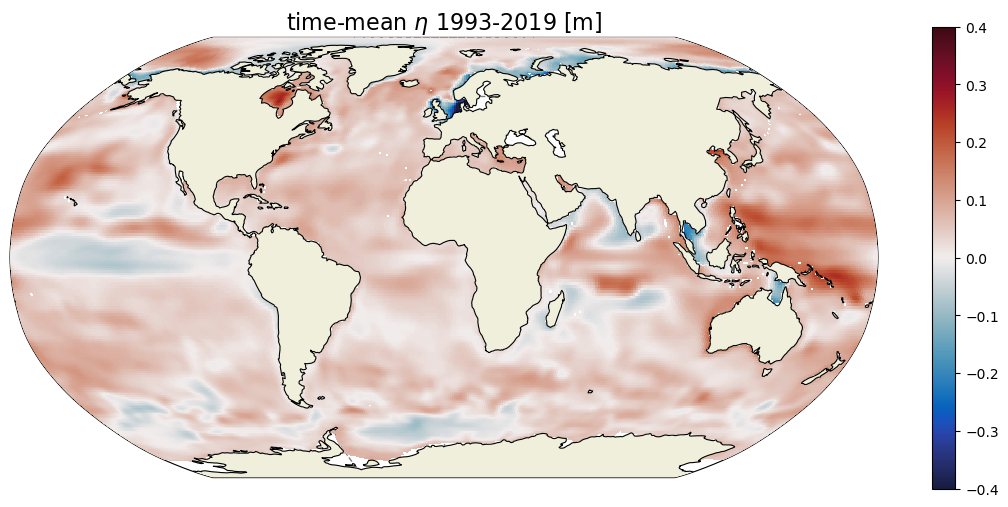

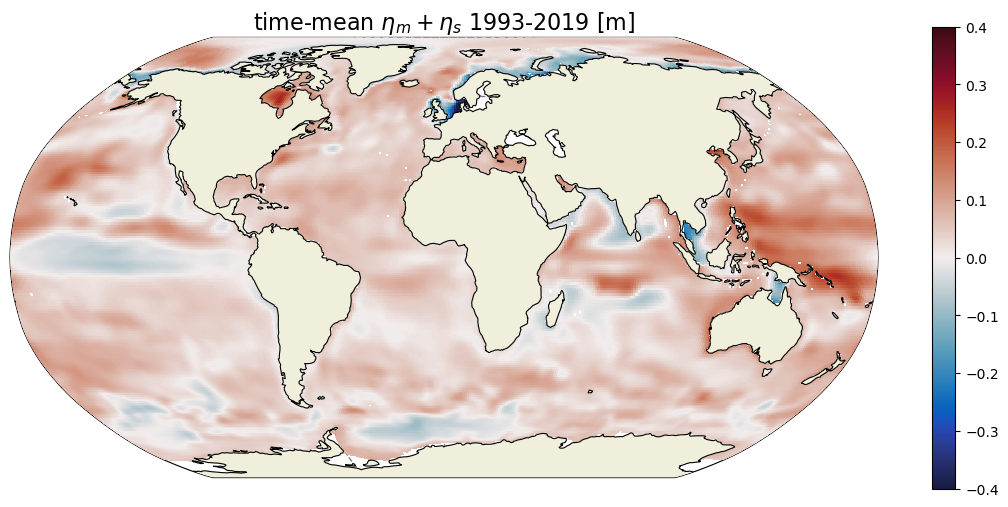

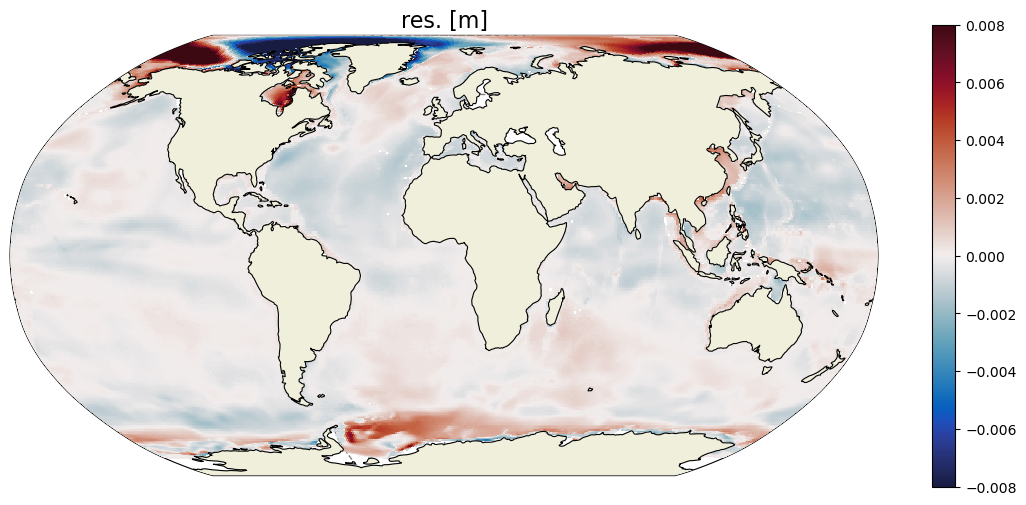

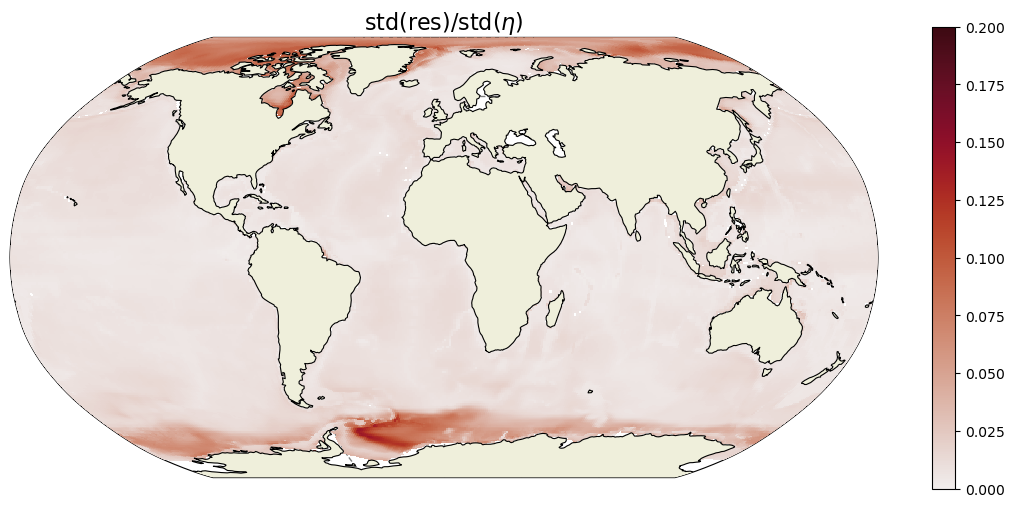

In [53]:
eta_tm = eta_anom[:,:,:,:].mean(dim='time')
etam_tm = etam_anom[:,:,:,:].mean(dim='time')
etas_tm = etas_anom[:,:,:,:].mean(dim='time')
etaCOR_tm = etaCOR_anom[:,:,:,:].mean(dim='time')

res_tm = eta_tm - etam_tm - etas_tm# - etaCOR_tm

# -- errors
# relerr = (eta_anom - etam_anom - etas_anom) / eta_anom
std_re = (eta_anom - etam_anom - etas_anom).std(dim='time') / eta_anom.std(dim='time')
corr_eta = xr.corr(eta_anom, etam_anom+etas_anom, dim="time")

rat = abs(res_tm/eta_tm)

plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,eta_tm, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-.4, cmax=.4, 
                              cmap=cmocean.cm.balance)
plt.title('time-mean $\eta$ 1993-2019 [m]',fontsize=16)
plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/eta_tm.png", dpi=600, bbox_inches='tight')

# plt.figure(figsize=[14,6])
# ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,etaCOR_tm, 
#                               show_colorbar=True,
#                               show_grid_lines=True,
#                               cmin=-2e-2, cmax=2e-2, 
#                               cmap=cmocean.cm.balance)
# plt.title('mean $\eta$ COR 1993-2019',fontsize=16)

plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,etam_tm+etas_tm, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-.4, cmax=.4, 
                              cmap=cmocean.cm.balance)
plt.title('time-mean $\eta_m + \eta_s$ 1993-2019 [m]',fontsize=16)
plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/eta_rec_tm.png", dpi=600, bbox_inches='tight')


plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,res_tm, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-8e-3, cmax=8e-3, 
                              cmap=cmocean.cm.balance)
plt.title('res. [m]',fontsize=16)
plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/res_eta_tm.png", dpi=600, bbox_inches='tight')

# plt.figure(figsize=[14,6])
# ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,(sIceLoad/rhoConst)[1,:,:,:], 
#                               show_colorbar=True,
#                               show_grid_lines=True,
#                               cmin=-5, cmax=5, 
#                               cmap=cmocean.cm.balance)
# plt.title('load',fontsize=16)

plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,std_re, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=0, cmax=.2, 
                              cmap=cmocean.cm.amp)
plt.title('std(res)/std($\eta$)',fontsize=16)
plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/std_res.png", dpi=600, bbox_inches='tight')

# plt.figure(figsize=[14,6])
# ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,corr_eta, 
#                               show_colorbar=True,
#                               show_grid_lines=True,
#                               cmin=-1, cmax=1, 
#                               cmap=cmocean.cm.balance)
# plt.title('corr($\eta$,$\eta_m + \eta_s$)',fontsize=16)

# sIceLoad/rhoConst


<xarray.DataArray ()> Size: 4B
array(0.00224678, dtype=float32)
Coordinates:
    tile     int32 4B 0
<xarray.DataArray 'SSH' ()> Size: 4B
array(0.04706466, dtype=float32)
Coordinates:
    tile     int32 4B 6


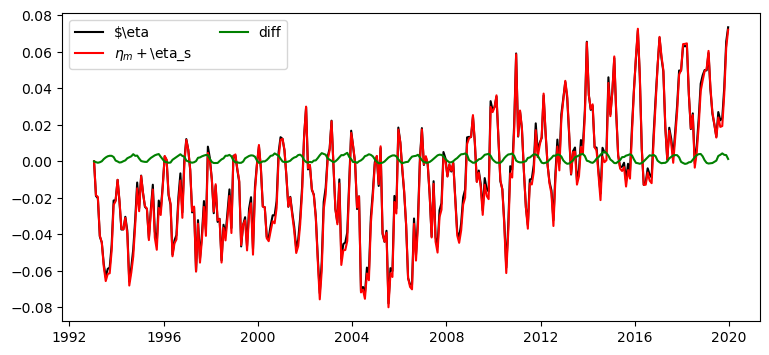

In [67]:
res = eta_anom - etam_anom - etas_anom

# help(ecco.plot_proj_to_latlon_grid)
fmean = res.weighted(ds_grid.rA).mean(dim=("j", "i")) 
fmean_s = etas_anom.weighted(ds_grid.rA).mean(dim=("j", "i")) 
fmean_re = (etas_anom+etam_anom).weighted(ds_grid.rA).mean(dim=("j", "i")) 
fmean_eta = eta_anom.weighted(ds_grid.rA).mean(dim=("j", "i")) 
fmean_etan = etan_anom.weighted(ds_grid.rA).mean(dim=("j", "i")) 

fmean

# plt.figure(figsize=(9,4))
# plt.plot(fmean['time'], fmean[:,0], label='res', color='k')
# plt.plot(fmean_s['time'], fmean_s[:,0], label='$\eta_s$', color='r')
# plt.legend(ncol=2)

plt.figure(figsize=(9,4))
plt.plot(fmean_eta['time'], fmean_eta[:,0], label='$\eta$', color='k')
plt.plot(fmean_re['time'], fmean_re[:,0], label='$\eta_m + $\eta_s$', color='r')
plt.plot(fmean_eta['time'], fmean_eta[:,0] - fmean_re[:,0], label='diff', color='g')
# plt.plot(fmean_etan['time'], fmean_etan[:,0], label='diff', color='m')
plt.legend(ncol=2)

ress = fmean_eta[:,0] - fmean_re[:,0]
rms_ds = np.sqrt((ress ** 2).mean())
print(rms_ds) # 0.00151152

ress = fmean_eta[:,6]
rms_ds = np.sqrt((ress ** 2).mean())
print(rms_ds) # 0.00151152

# 0.00151152/0.04038097

In [16]:
# ds_PRE
fmean_eta.shape

(96, 13)

array(0.14266255, dtype=float32)

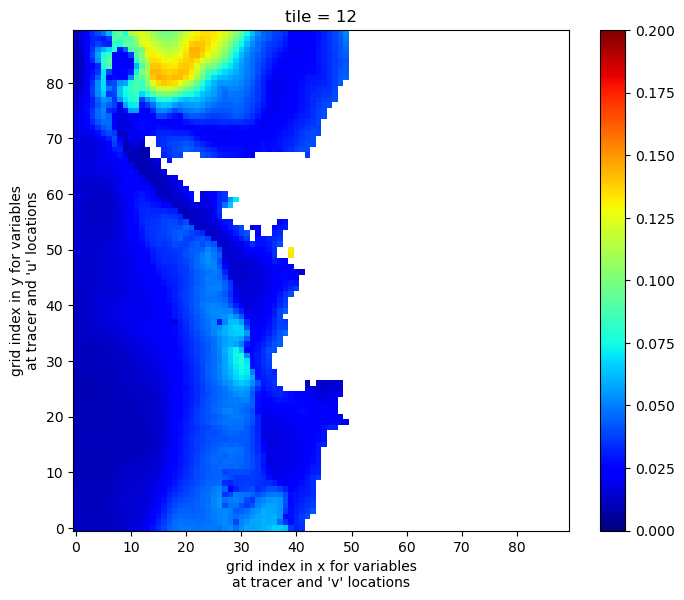

In [70]:
# ecco.plot_tile(6)
# 
fig=plt.figure(figsize=(8, 6.5))
std_re.isel(tile=12).plot(vmin=0, vmax=.2, cmap='jet') # tile = 10

std_re[12,81,18].values

# std_re.max()

(<Figure size 1400x600 with 2 Axes>,
 <GeoAxes: >,
 array([[-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        ...,
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875]]),
 array([[-89.875, -89.875, -89.875, ..., -89.875, -89.875, -89.875],
        [-89.625, -89.625, -89.625, ..., -89.625, -89.625, -89.625],
        [-89.375, -89.375, -89.375, ..., -89.375, -89.375, -89.375],
        ...,
        [ 89.375,  89.375,  89.375, ...,  89.375,  89.375,  89.375],
        [ 89.625,  89.625,  89.625, ...,  89.625,  89.625,  89.625],
        [ 89.875,  89.875,  89.875, ...,  89.875,  89.875,  89.875]]),
 masked_array(
   data=[[      nan,       nan,       na

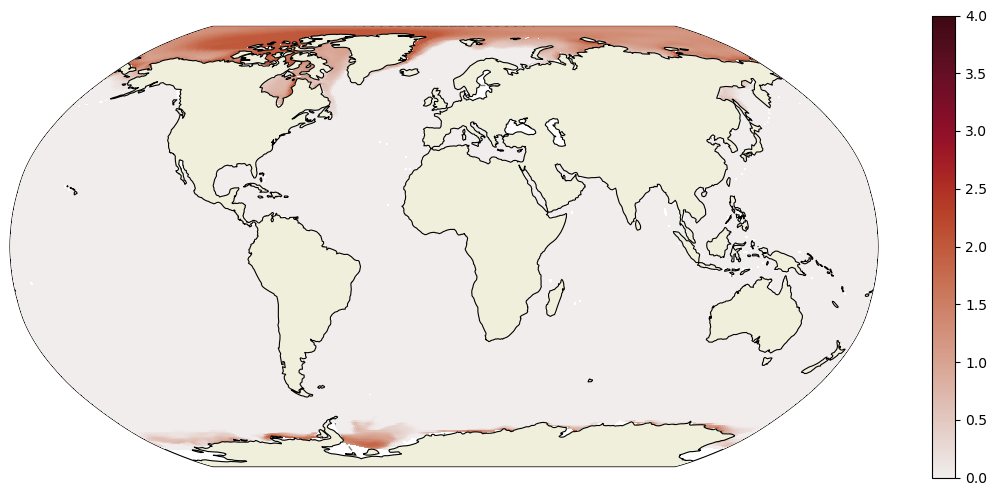

In [28]:
plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,(sIceLoad/rhoConst)[0,:,:,:].squeeze(), 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=0, cmax=4, 
                              cmap=cmocean.cm.amp)


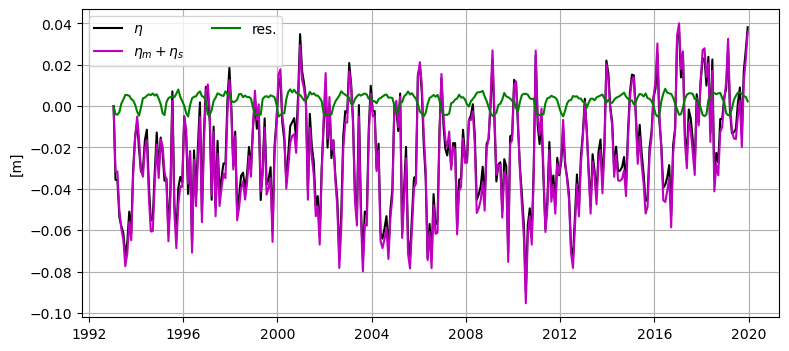

In [92]:
# eta_anom.isel(tile=6, j = 65, i = 80).plot()

plt.figure(figsize=(9,4))
plt.plot(eta_anom['time'], eta_anom[:,12,81,18], label='$\eta$', color='k')
plt.plot(eta_anom['time'], etam_anom[:,12,81,18] + etas_anom[:,12,81,18], label='$\eta_m + \eta_s$', color='m')
plt.plot(eta_anom['time'], res[:,12,81,18], label='res.', color='g')
plt.legend(ncol=2)
# plt.ylim(-5, 30)
plt.ylabel('[m]')
plt.legend(ncol=2)
plt.grid(True) 

plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/SSH_recons_point.png", dpi=600, bbox_inches='tight')

# plt.figure(figsize=(9,4))
# SIheff.isel(tile=6, j = 65, i = 80).plot()
# sIceLoad.isel(tile=6, j = 65, i = 80).plot()
# plt.plot(sIceLoad['time'], sIceLoad[:,6,65,80], label='load', color='k')


In [30]:
75000/1029/10

7.288629737609329

In [91]:
sIceLoad

<xarray.DataArray 'sIceLoad' (time: 324, tile: 13, j: 90, i: 90)> Size: 136MB
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan]]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-16
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    comment:                Total mass of sea-ice and snow in a model grid ce...
    coverage_content_type:  modelResult
    long_name:              Average sea-ice and snow mass per unit area
    standard_name:          sea_ice_and_surface_snow_amount
    units:                  kg m-2
    valid_max:              2058.0
    valid_min:              0.0

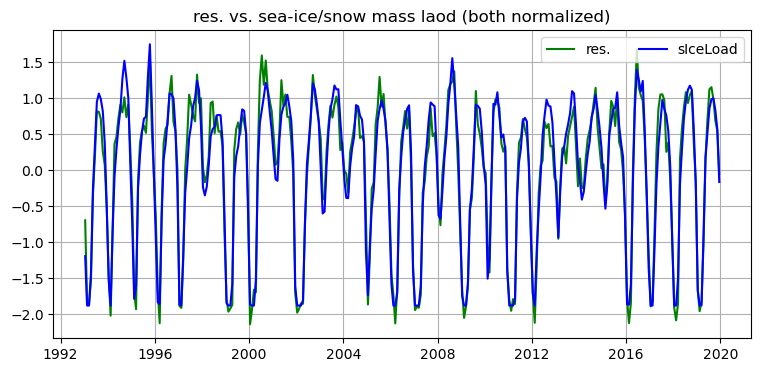

In [98]:
#plt.plot(eta_anom['time'], eta_anom[:,6,65,80] - etam_anom[:,6,65,80]-etas_anom[:,6,65,80], label='diff', color='g')
# a = eta_anom[:,6,65,80] - etam_anom[:,6,65,80]-etas_anom[:,6,65,80]
# b = sIceLoad.isel(tile=6, j = 65, i = 80)

a = res[:,12,81,18]
b = sIceLoad[:,12,81,18]

# norm_ds = (ds - ds.mean(dim="time")) / ds.std(dim="time")
a_norm = (a - a.mean(dim="time")) / a.std(dim="time")
b_norm = (b - b.mean(dim="time")) / b.std(dim="time")

plt.figure(figsize=(9,4))
# plt.subplot(2, 1, 1)
plt.plot(a_norm['time'], a_norm, 'g', label='res.')
# plt.subplot(2, 1, 2)
plt.plot(b_norm['time'],b_norm, color='b', label='sIceLoad')
plt.title('res. vs. sea-ice/snow mass laod (both normalized)')
# plt.plot(a - np.mean(a))
# plt.plot((b - np.mean(b))/610/10/9.8, color='r')
plt.legend(ncol=2)
plt.grid(True) 

plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/SSH_recons_point_wsIceLoad.png", dpi=600, bbox_inches='tight')



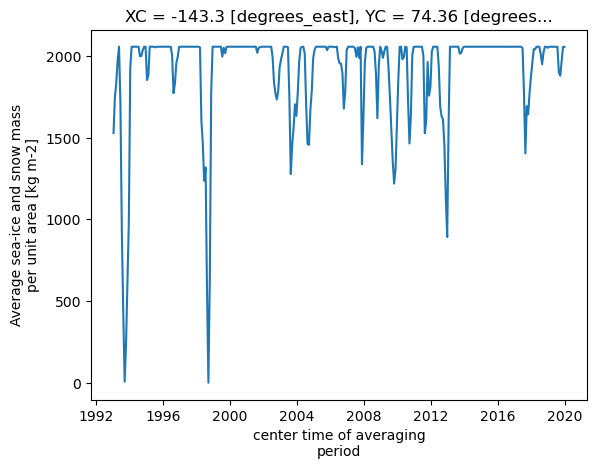

In [77]:
sIceLoad.isel(tile=6, j = 65, i = 80).plot()

In [24]:
ds_ICE

<xarray.Dataset> Size: 571MB
Dimensions:    (time: 336, tile: 13, j: 90, i: 90, nb: 4, j_g: 90, i_g: 90,
                nv: 2)
Coordinates: (12/13)
  * time       (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
    XC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    ...         ...
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(2, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables:
    SIarea     (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    SIheff     (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    SIhsnow    (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    sIceLoad   (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea-Ice and Snow Concentration and Thi...
    uuid:                         b39388a8-271e-11f0-ae31-0a58a9feac02